In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
import re
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize

sys.path.append("..") 
from eventepi.event_db_preprocessing import event_db
from eventepi.pipeline import RecommenderLabeling, RecommenderTierAnnotation, CleanEventDB

Using TensorFlow backend.


# URL clustering

In [44]:
import os

from urllib.parse import urlparse
from collections import defaultdict
from operator import itemgetter
import matplotlib.pyplot as plt
from eventepi.pipeline import CleanEventDB

In [27]:
cleaned_edb = CleanEventDB().data_output()
urls = cleaned_edb.URL
netlocs = [urlparse(url).netloc for url in urls]
d = defaultdict(int)
for n in netlocs:
    d[n] = d[n] + 1
netloc_occurence_tuples = list(d.items())

In [28]:
sorted_netloc_occurence_tuples = sorted(netloc_occurence_tuples, key=itemgetter(1))

In [30]:
# Amount of netlocs
len(sorted_netloc_occurence_tuples)

77

In [32]:
nine_most_used_netlocs = sorted_netloc_occurence_tuples[-9:]

In [33]:
nine_most_used_netlocs

[('ecdc.europa.eu', 6),
 ('polioeradication.org', 6),
 ('www.euro.who.int', 6),
 ('www.who.int', 22),
 ('www.cidrap.umn.edu', 30),
 ('outbreaknewstoday.com', 50),
 ('apps.who.int', 74),
 (b'', 87),
 ('www.promedmail.org', 163)]

In [71]:
nine_most_used_netlocs.remove((b'', 87))

In [36]:
nine_most_used_netlocs = sorted(nine_most_used_netlocs, key=itemgetter(1))

In [74]:
nine_most_used_netlocs

[('ecdc.europa.eu', 6),
 ('polioeradication.org', 6),
 ('www.euro.who.int', 6),
 ('www.who.int', 22),
 ('www.cidrap.umn.edu', 30),
 ('outbreaknewstoday.com', 50),
 ('apps.who.int', 74),
 ('www.promedmail.org', 163)]

In [40]:
# Calculate the usage of other netlocs
number_usage_other_netlocs = sum(i for _, i in sorted_netloc_occurence_tuples)  - sum(i for _, i in nine_most_used_netlocs) 

In [41]:
most_used_and_other_netlocs = [('other netlocs', number_usage_other_netlocs)]
most_used_and_other_netlocs.extend(nine_most_used_netlocs)

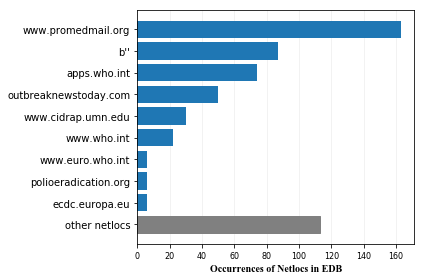

In [139]:
x = np.arange(len(most_used_and_other_netlocs))
bars = plt.barh(x, width=[t[1] for t in most_used_and_other_netlocs])
bars[0].set_color('grey')
plt.xlabel('Occurrences of Netlocs in EDB', fontname='Times New Roman')
plt.yticks(x, [t[0] for t in most_used_and_other_netlocs])
plt.xticks(fontsize=8)
plt.grid(which='both', axis='x', alpha=0.2)
plt.rc('axes', axisbelow=True)
plt.tight_layout()
path = os.path.join("..", "plots", "netloc.pdf")
plt.savefig('netloc.pdf', format='pdf', frameon=False)

# Cleaning Statistics

In [137]:
edb = event_db._read_unprocessed()
cleaned_edb = event_db.read_cleaned()
print("incident database entries", len(edb))
print("incident database entries after preprocessing", len(cleaned_edb))

incident database entries 484
incident database entries after preprocessing 557


## Date

In [71]:
print('There are', len(cleaned_edb), 'entries in the event db')
print(sum(cleaned_edb["date_of_data"].notna()), 'of them are non-empty dates.')

There are 557 entries in the event db
229 of them are non-empty dates.


In [72]:
timestamps = edb['Datenstand für Fallzahlen gesamt*'].replace(['nan', '-', np.nan], [None] * 3).tolist()
valid_ts = list(filter(lambda x: isinstance(x, str), timestamps))

is_date = lambda x: re.match(r"(\d{1,2})\D(\d{1,2})\D(\d{4})", x)

In [73]:
print('The following are non-valid non-empty dates:')
print(list(filter(lambda x: not is_date(x), valid_ts)))

The following are non-valid non-empty dates:
['?', 'Ende Mai', '43329', '43332', '43332', '43335', '43336', '43335', '43335', '43340', '43340', 'Mitte Sept.', '13.10.218', 'September 2018', '2017', '2018', 'Jan-4.Nov 2018', 'July 2017 -22.10.2018', 'Juni-Nov 2018']


## Count

In [58]:
print('There are', len(cleaned_edb), 'entries in the cleaned event db')
print(sum(cleaned_edb['count_edb'].notna()), 'of them are non-empty case numbers')

There are 484 entries in the cleaned event db
394 of them are non-empty case numbers


In [79]:
valid_counts = edb['Fälle gesamt*'].notna()
print('Valid EDB counts: ', sum(valid_counts))

Valid EDB counts:  299


In [80]:
valid_counts_cleaned = cleaned_edb['count_edb'].notna()

In [81]:
print('Valid cleaned EDB counts: ', sum(valid_counts_cleaned))

Valid cleaned EDB counts:  394


In [82]:
def is_int(string):
    try:
        num = int(string)
    except ValueError:
        return False
    return True

In [86]:
print('These are the invalid count entries:')
print(list(filter(lambda x: not is_int(x), edb['Fälle gesamt*'][valid_counts])))

These are the invalid count entries:
['1,078,997', '40 abzgl. 19 non-cases', 'mind 18', '368 Fälle', '6,382', '0 bei Menschen.\nMehr als 50 Todesfälle bei Kühem. Schafen und Pferden', '4 cVDPV2\n2 WPV1 in Afghanistan', '>1000', '>3.300', '13 430', '15,944', '1,207,596', '650,000', '3,057', '446.150', 'erhöhte Fallzahlen seit 2013', '25 (im Jahr 2018)', '10.604']


In [87]:
len(list(filter(lambda x: not is_int(x), edb['Fälle gesamt*'][valid_counts])))

18

## Country

In [33]:
from eventepi.pipeline import CleanCountryLookUpAndAddAbbreviations
before = set(edb['Ausgangs- bzw. Ausbruchsland'])
after = set(cleaned_edb.country_edb)
print(before - after)
print('\n is cleaned to: \n')
print(after - before)

{nan, 'Afghanistan,\nDR Congo\nNigeria\nSomalia', 'Venezuela ', 'Italien, Serbien, Griechenland, Rumänien, Ungarn, Frankreich, Kosovo, Albanien, Macedonien, Montenegro, Serbien, Türkei', 'Französich_Polynesien', 'Saudi-Arabien ', 'VAE ', 'Namibia, Opuwo District, Kunene Region', 'Nigeria, Edo State', 'Indien, Jaipur', 'DRC, Nord Kivu', ' Äthiopien (AWD)', 'USA, Delaware', 'Trinidad & Tobago', 'Peru ', 'Italien, Griechenland, Ungarn, Rumänien', 'Oman ', 'Serbien, Italien, Griechenland, Ungarn,  Rumänien', 'Italien, Griechenland, Rumanien, Ungarn, Frankreich'}

 is cleaned to: 

{None, 'Französich Polynesien', 'Kunene Region', 'Jaipur', 'Trinidad und Tobago', 'Kosovo', 'Griechenland', 'Delaware', 'Montenegro', 'Rumänien', 'Rumanien', 'Ungarn', 'VAE', 'Nord Kivu', 'Macedonien', 'DR Congo', 'Edo State', 'Albanien', 'Serbien', 'Oman', 'Opuwo District'}


In [53]:
country_lookup = CleanCountryLookUpAndAddAbbreviations().data_output()

In [83]:
valid_before_preprocessing = list(filter(lambda x: x in country_lookup, edb['Ausgangs- bzw. Ausbruchsland']))
print('Valid entries before controlled vocabulary: ', len(valid_before_preprocessing))

Valid entries before controlled vocabulary:  355


In [84]:
valid_after_preprocessing = list(filter(lambda x: x in country_lookup, cleaned_edb.country_edb))
print('Valid entries after controlled vocabulary: ', len(valid_after_preprocessing))

Valid entries after controlled vocabulary:  494


In [77]:
print('Invalid entries: ', len(after-before))

Invalid entries:  21


In [28]:
# Stripped strings don't appear in the last set but were processed correctly
('Peru' in after) & ('Saudi-Arabien' in after) & ('Oman' in after) & ('Äthiopien' in after)

True

## Disease

In [130]:
from eventepi.pipeline import MergeDiseaseNameLookupWithAbbreviationsOfRKI
disease_lookup = MergeDiseaseNameLookupWithAbbreviationsOfRKI().data_output()

before_disease =  set(edb['Krankheitsbild(er)'])
after_disease = set(cleaned_edb['disease_edb'])
print('Not valid: ',  before_disease - after_disease)
print('Not valid in numbers: ', len(before_disease - after_disease))

Not valid:  {nan, '?', 'keine', 'Husten, Fieber', 'AFP, AFM', 'Tick-borne relapsing fever ', 'FSME ', 'Lassafieber ', ' ', 'Camel Prion Disease ', 'Diarrhoe, Überkeit, Erbrechen', 'Gonorrhö, multiresistent', 'Nierenversagen; v.a. HUS, Leptospirose', 'Gesichtslähmung, Nervensystem betroffen.', 'Tularämie ', 'Leptospirose '}
Not valid in numbers:  16


In [131]:
valid_diseases_before_preprocessing = (list(filter(lambda x: x in disease_lookup, edb['Krankheitsbild(er)'])))
print('Valid entries before controlled vocabulary: ', len(valid_diseases_before_preprocessing))

Valid entries before controlled vocabulary:  231


In [132]:
valid_diseases_after_preprocessing = (list(filter(lambda x: x in disease_lookup, cleaned_edb['disease_edb'])))
print('Valid entries after controlled vocabulary: ', len(valid_diseases_after_preprocessing))

Valid entries after controlled vocabulary:  332


In [138]:
cleaned_edb_valid_URL = cleaned_edb[cleaned_edb.URL.notna()]

In [139]:
cleaned_edb_valid_URL = cleaned_edb_valid_URL[cleaned_edb_valid_URL.URL.str.contains(r'(/don/|promed)', regex=True)]

/home/auss/miniconda3/envs/rki/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


## URLs

In [88]:
before_URLs =  set(edb['Link zur Quelle 1'])
after_URLs = set(cleaned_edb['URL'])

In [90]:
# Following URLs were not valid due to guillements, splitting by comma, additional whitespace, and being non-URLs
before_URLs - after_URLs

{'<http://apps.who.int/iris/bitstream/10665/260468/1/OEW10-39032018.pdf>',
 '<http://apps.who.int/iris/bitstream/10665/260468/1/OEW10-39032018.pdf>, <http://www.ncdc.gov.ng/diseases/sitreps>',
 '<http://apps.who.int/iris/bitstream/10665/260468/1/OEW10-39032018.pdf>, <http://www.nicd.ac.za/wp-content/uploads/2018/03/Listeria-Sitrep-08Mar2018.pdf>',
 'ECDC RRA 10 Aug 2018 Early occurrence of a large number of WNV infection.._',
 'Siehe Email',
 'http://apps.who.int/iris/bitstream/handle/10665/272360/OEW15-071342018.pdf ',
 'http://apps.who.int/iris/bitstream/handle/10665/272431/OEW17-2127042018.pdf ',
 'http://apps.who.int/iris/bitstream/handle/10665/274791/OEW38-1521092018.pdf ',
 'http://crofsblogs.typepad.com/h5n1/2018/03/brazil-moh-updates-yellow-fever-cases.html, http://portalarquivos2.saude.gov.br/images/pdf/2018/marco/07/Informe-FA-16-7mar18.pdf   ECDC RRA vom 14.03.2018',
 'http://portalarquivos2.saude.gov.br/images/pdf/2018/abril/26/Informe-FA-23-25abr18.pdf ',
 'http://promedma

# Pipeline

In [5]:
from eventepi.pipeline import *

In [99]:
CleanEventDB().data_output().head()

,date_of_data,count_edb,country_edb,disease_edb,URL
0,2018-03-18,1121.0,Nigeria,Lassafieber,http://apps.who.int/iris/bitstream/10665/26046...
1,2018-03-18,1121.0,Nigeria,Lassafieber,http://www.ncdc.gov.ng/diseases/sitreps
2,2018-03-05,24.0,Benin,Lassafieber,http://apps.who.int/iris/bitstream/10665/26046...
3,2018-03-16,42.0,Liberia,Lassafieber,http://apps.who.int/iris/bitstream/10665/26046...
4,2018-03-02,1.0,Ghana,Lassafieber,http://apps.who.int/iris/bitstream/10665/26046...


In [100]:
RequestDiseaseNamesFromWikiData().data_output().head()

,itemLabel_DE,itemLabel_EN
0,Masern,measles
1,oromandibuläre Dystonie,oromandibular dystonia
2,Lemierre-Syndrom,Lemierre's syndrome
3,Frambösie,yaws
4,Ovarialkarzinom,ovarian cancer


In [101]:
ScrapeCountryNamesFromWikipedia().data_output().head()

,state_name_de,full_state_name_de,translation_state_name,iso_three_abbreviation,iso_two_abbreviation
0,Erde,—,Earth,—,—
1,Europäische Union,—,European Union,—,EU
2,Union Südamerikanischer Nationen,—,Union of South American Nations,—,UNASUL
3,Afrikanische Union,—,African Union,—,—
4,Verband Südost­asiatischer Nationen,—,Association of Southeast Asian Nations,—,—


In [102]:
CleanCountryLookUpAndAddAbbreviations().data_output()

{'RA': 'Republic of Artsakh',
 'IRA': 'Afghanistan',
 'ARÄ': 'Egypt',
 'DVA': 'Algeria',
 'FA': 'Andorra',
 'AB': 'Antigua and Barbuda',
 'RÄ': 'Equatorial Guinea',
 'AR': 'Argentina',
 'DBÄ': 'Ethiopia',
 'CB': 'Bahamas',
 'KB': 'Bhutan',
 'VB': 'Bangladesh',
 'RB': 'Belarus',
 'PSB': 'Bolivia',
 'BH': 'Bahrain',
 'FRB': 'Brazil',
 'BD': 'Bangladesh',
 'BF': 'Burkina Faso',
 'RC': 'Republic of Congo',
 'VC': 'Saint Vincent and the Grenadines',
 'RCR': 'Costa Rica',
 'KD': 'Denmark',
 'CD': 'Democratic Republic of the Congo',
 'DR': 'Dominican Republic',
 'RD': 'Djibouti',
 'RE': 'Estonia',
 'RES': 'El Salvador',
 'RCI': 'Ivory Coast',
 'SE': 'Sweden',
 'RF': 'Russia oder Russian Federation',
 'FR': 'France',
 'GR': 'Greece',
 'RG': 'Guinea',
 'HR': 'Croatia',
 'RGB': 'Guinea-Bissau',
 'KRG': 'Guyana',
 'RH': 'Honduras',
 'RI': 'Iceland',
 'IRI': 'Iran',
 'SI': 'Slovenia',
 'IR': 'Iran',
 'RJ': 'Yemen',
 'HKJ': 'Jordan',
 'KK': 'Cambodia',
 'RK': 'Republic of Korea',
 'RCV': 'Cape Verd

In [103]:
MergeDiseaseNameLookupWithAbbreviationsOfRKI().data_output()

{'MSV': 'measles',
 'MPV': 'mumps',
 'SPY': 'scarlet fever',
 'STY': 'typhoid fever',
 'NEG': 'gonorrhea',
 'BAN': 'anthrax',
 'YPS': 'plague',
 'COR': 'diphtheria',
 'GIL': 'giardiasis',
 'HEV': 'hepatitis E',
 'SAL': 'salmonellosis',
 'TRI': 'trichinosis',
 'HDV': 'hepatitis D',
 'BPS': 'pertussis',
 'CLO': 'botulism',
 'HCV': 'hepatitis C',
 'FRT': 'tularemia',
 'GFV': 'yellow fever',
 'BRU': 'brucellosis',
 'RUV': 'rubella',
 'HAV': 'hepatitis A',
 'LIS': 'listeriosis',
 'RIC': 'spotted fever',
 'CHL': 'ornithosis',
 'COX': 'Q fever',
 'LEP': 'leptospirosis',
 'LEG': "legionnaires' disease",
 'MBV': 'Marburg virus disease',
 'GBR': 'gas gangrene',
 'HFM': 'hand, foot and mouth disease',
 'LSV': 'Lassa fever',
 'SPA': 'paratyphoid fever',
 'BOB': 'borreliosis',
 'PVB': 'erythema infectiosum',
 'ECH': 'echinococcosis',
 'ECC': 'echinococcosis',
 'YEN': 'yersiniosis',
 'INV': 'influenza',
 'HBV': 'hepatitis B',
 'VCH': 'cholera',
 'PLA': 'malaria',
 'PLM': 'malaria',
 'POV': 'poliomye

In [104]:
ApplyControlledVocabularyToEventDB().data_output().head()

,date_of_data,count_edb,country_edb,disease_edb,URL
0,2018-03-18,1121.0,Nigeria,Lassa fever,http://apps.who.int/iris/bitstream/10665/26046...
1,2018-03-18,1121.0,Nigeria,Lassa fever,http://www.ncdc.gov.ng/diseases/sitreps
2,2018-03-05,24.0,Benin,Lassa fever,http://apps.who.int/iris/bitstream/10665/26046...
3,2018-03-16,42.0,Liberia,Lassa fever,http://apps.who.int/iris/bitstream/10665/26046...
4,2018-03-02,1.0,Ghana,Lassa fever,http://apps.who.int/iris/bitstream/10665/26046...


In [105]:
ScrapePromed('2018').data_output().head()

,URL
0,https://www.promedmail.org/post/6237302
1,https://www.promedmail.org/post/6236998
2,https://www.promedmail.org/post/6236997
3,https://www.promedmail.org/post/6236702
4,https://www.promedmail.org/post/6235503


In [106]:
ScrapeWHO('2018').data_output().head()

,URL
0,http://www.who.int/csr/don/28-december-2018-eb...
1,http://www.who.int/csr/don/28-december-2018-me...
2,http://www.who.int/csr/don/27-december-2018-ty...
3,http://www.who.int/csr/don/20-december-2018-eb...
4,http://www.who.int/csr/don/18-December-2018-ye...


In [108]:
ScrapeFromURLsAndExtractText('who').data_output().head()

,URL,extracted_text
0,http://www.who.int/csr/don/28-december-2018-eb...,Ebola virus disease – Democratic Republic of t...
1,http://www.who.int/csr/don/28-december-2018-me...,Middle East respiratory syndrome coronavirus (...
2,http://www.who.int/csr/don/27-december-2018-ty...,Typhoid fever – Islamic Republic of Pakistan D...
3,http://www.who.int/csr/don/20-december-2018-eb...,Ebola virus disease – Democratic Republic of t...
4,http://www.who.int/csr/don/18-December-2018-ye...,Yellow Fever – Kingdom of the Netherlands Dise...


In [109]:
ScrapeFromURLsAndExtractText('promed').data_output().head()

,URL,extracted_text
0,https://www.promedmail.org/post/6237302,New suspected cases in reporting month: 15 New...
1,https://www.promedmail.org/post/6236998,- Sat 29 Dec 2018. Press Release [Internationa...
2,https://www.promedmail.org/post/6236997,"Measles update (80): Europe, Pacific, Asia, Am..."
3,https://www.promedmail.org/post/6236702,ProMED-mail is a program of the International ...
4,https://www.promedmail.org/post/6235503,ProMED-mail is a program of the International ...


In [111]:
ExtractSentencesAndLabel('dates').data_output().head()

,sentence,label
0,Excerpt from the Google translation:The Minist...,False
1,Thus the period for the analysis considers fro...,False
2,Disease outbreak news9 April 2018On 2 March 20...,True
3,Disease outbreak news9 April 2018On 2 March 20...,False
4,Disease outbreak news9 April 2018On 2 March 20...,False


In [112]:
ExtractSentencesAndLabel('counts').data_output().head()

,sentence,label
0,Subscribe to NewsletterMandate of NCDCThe Nige...,False
1,Subscribe to NewsletterMandate of NCDCThe Nige...,False
2,Subscribe to NewsletterMandate of NCDCThe Nige...,False
3,"Abuja, 25 January 2019 – In an historic event ...",False
4,"Abuja, 25 January 2019 – In an historic event ...",False


In [113]:
RecommenderLabeling().data_output().head()

,extracted_text,label
0,Ebola virus disease – Democratic Republic of t...,False
1,Middle East respiratory syndrome coronavirus (...,False
2,Typhoid fever – Islamic Republic of Pakistan D...,False
3,Ebola virus disease – Democratic Republic of t...,False
4,Yellow Fever – Kingdom of the Netherlands Dise...,False


# Recommender System

In [114]:
# Amount of WHO articles in the year 2018
len(ScrapeWHO('2018').data_output())

91

In [115]:
# Amount of ProMED articles in the year 2018
len(ScrapePromed('2018').data_output())

3141

In [126]:
recommender_df = RecommenderLabeling().data_output()
print("There are ", sum(recommender_df.label), "incident database entries that match the scraped WHO and ProMED articles")

There are  160 incident database entries that match the scraped WHO and ProMED articles


In [140]:
# Fix bad tokenization due to boilerpipe merging of paragraph tags like 'gone.However'

recommender_df["extracted_text"] = recommender_df["extracted_text"].apply(lambda x: 
                                                                          re.sub(r"([0-9a-zA-Z]+)\.([A-Za-z]+\s)",
                                                                                 r"\g<1>. \g<2>",
                                                                                 x)
                                                                         )
                        
all_the_texts = ' '.join(recommender_df["extracted_text"])

all_the_texts_tokenized = word_tokenize(all_the_texts)

print("Token in the corpus: ", len(all_the_texts_tokenized))

Token in the corpus:  2791680


# Recommenter Tier Annotations

In [138]:
recommender_tier_df = RecommenderTierAnnotation().data_output()

## Relevant articles without an extracted entity given all entitiy classes

In [128]:
sum(recommender_tier_df[recommender_tier_df.label == True].date.isna())

2

In [129]:
sum(recommender_tier_df[recommender_tier_df.label == True].counts.isna())

0

In [130]:
sum(recommender_tier_df[recommender_tier_df.label == True].diseases.isna())

23

In [131]:
sum(recommender_tier_df[recommender_tier_df.label == True].geoname.isna())

0